In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
%matplotlib inline

In [2]:
#Activation functions
def ReLU(x):
    x[x<0]=0
    return x

def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [3]:
#One hot encoding on matrix Y
def one_hot_encoding(Y,C = 10):
    one_hot = np.zeros((Y.size,C))
    rows = np.arange(Y.size)
    one_hot[rows,Y] = 1
    return one_hot.T

In [4]:
train_data = pd.read_csv('train.csv')

In [5]:
X_train ,y_train = train_data.drop(columns = ['label']).to_numpy() , train_data['label'].to_numpy().reshape(train_data.shape[0],1)
test_X = pd.read_csv('test.csv')
test_X = test_X.to_numpy().T
test_y = pd.read_csv('Do_not_submit.csv')['Label']

In [6]:
X_train = X_train.T
y_train = y_train.T

print('X_train shape = ',X_train.shape)
print('y_train shape = ',y_train.shape)

X_train shape =  (784, 42000)
y_train shape =  (1, 42000)


In [7]:
#Initializing weights
def initialize_parameters(X,hidden_nodes):
    np.random.seed(3)
    parameters = {}
    output_layer = 10
    parameters['W1'] = np.random.randn(hidden_nodes,X.shape[0]) * np.sqrt(2/X.shape[0])
    parameters['b1'] = np.zeros((hidden_nodes,1))
    parameters['W2'] = np.random.randn(output_layer,hidden_nodes) * np.sqrt(1/hidden_nodes)
    parameters['b2'] = np.zeros((output_layer,1))
    return parameters

In [8]:
#Creating mini batches tuples and appending them to mini_batches list
def mini_batches(X,Y,mini_batch_size = 128,seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    if Y is not 0:
        shuffled_Y = Y[:, permutation]
        amount_of_mini_batches = math.floor(m/mini_batch_size)
        for i in range(amount_of_mini_batches):
            mini_batch_X = X[:,i * mini_batch_size : (i + 1) * mini_batch_size]
            mini_batch_Y = Y[:,i * mini_batch_size : (i + 1) * mini_batch_size]
            mini_batches.append((mini_batch_X,mini_batch_Y))
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:,(i + 1) * mini_batch_size : m]
            mini_batch_Y = shuffled_Y[:,(i + 1) * mini_batch_size : m]
            mini_batches.append((mini_batch_X, mini_batch_Y))
    else:
        amount_of_mini_batches = math.floor(m/mini_batch_size)
        for i in range(amount_of_mini_batches):
            mini_batch_X = X[:,i * mini_batch_size : (i + 1) * mini_batch_size]
            mini_batches.append(mini_batch_X)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:,(i + 1) * mini_batch_size : m]
            mini_batches.append(mini_batch_X)
    return mini_batches

In [9]:
#Computing forward propagation and returning Z , A in cache
def forward_propagation(X,parameters):
    W1,b1,W2,b2 = parameters['W1'], parameters['b1'] , parameters['W2'] , parameters['b2']
    Z1 = np.dot(W1,X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = softmax(Z2)
    forward_prop_cache = {
        'Z1' : Z1,
        'A1' : A1,
        'Z2' : Z2,
        'A2' : A2
    }
    return forward_prop_cache

In [10]:
#Computing back propagation and returning the derivatives dw, db
def backpropagation(forward_prop_cache,parameters,X,Y,lambd):
    A1,A2,Z1,Z2 = forward_prop_cache['A1'] , forward_prop_cache['A2'],forward_prop_cache['Z1'],forward_prop_cache['Z2']
    W2 , W1= parameters['W2'] , parameters['W1'] 
    m = X_train.shape[1]

    dz2 = A2 - Y
    dw2 = (1/m) * np.dot(dz2,A1.T) + (lambd/m) * W2
    db2 = (1/m) * np.sum(dz2,keepdims=True,axis=1)
    da1 = np.dot(W2.T,dz2)
    dz1 = da1 * (Z1 > 0)
    dw1 = (1/m) * np.dot(dz1,X.T) + (lambd/m) * W1
    db1 = (1/m) * np.sum(dz1,keepdims=True,axis=1)
    derivatives = {
        'dw2':dw2,
        'db2':db2,
        'dw1':dw1,
        'db1':db1
    }
    
    return derivatives

In [11]:
#Updating the parameters after computing the forward and backward propagation
def update_params(learning_rate,derivatives,parameters):
    dw2 , db2 , dw1 , db1 = derivatives.values()
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W2 =  W2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2
    W1 =  W1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1
    return {'W1':W1,
            'b1':b1,
            'W2':W2,
            'b2':b2
           }

In [12]:
#Computing the cost function
def cost_function(forward_prop_cache,Y,lambd,parameters):
    A2 = forward_prop_cache['A2']
    W1 , W2 = parameters['W1'] , parameters['W2']
    m = A2.shape[1]
    L2_regularization_cost = lambd/(2*m)* ( sum([np.sum(np.square(W)) for W in [W1,W2]]) )
    
    loss = (np.log(A2) * Y).sum(axis=1)
    return -np.mean(loss) + L2_regularization_cost

In [13]:
def model(num_iterations,X,Y,learning_rate,hidden_nodes,test_x,test_y,lambd=0.7):
    one_hot_Y = one_hot_encoding(Y)
    cost = []
    parameters = initialize_parameters(X,hidden_nodes)
    minibatches = mini_batches(X,one_hot_Y)
    #Training the model
    for i in range(num_iterations):
        np.random.shuffle(minibatches)
        for minibatch in minibatches:
            #Unpacking minibatch tuple to X_batch and one_hot_Y_batch
            X_batch , one_hot_Y_batch = minibatch
            
            #Computing forward prop - returns cache of Z,A
            forward_prop_cache = forward_propagation(X_batch,parameters)
            
            #Computing the derivatives - returns derivatives dw,db
            derivatives = backpropagation(forward_prop_cache,parameters,X_batch,one_hot_Y_batch,lambd)
            
            #Updating the parameters - returns updated parameters W,b
            parameters = update_params(learning_rate,derivatives,parameters)
            
        if i % 10 == 0:
            #Computing cost - returns cost
            current_cost = cost_function(forward_prop_cache,one_hot_Y_batch,lambd,parameters)
            cost.append(current_cost)
            print(f'i = {i} cost = {current_cost}')

    #Computing training accuracy
    y_train_pred_parameters = forward_propagation(X,parameters)
    y_train_pred = y_train_pred_parameters['A2']
    print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_train_pred, axis=0)== Y)))
    return cost , parameters,forward_prop_cache

In [14]:
lambd = 3
learning_rate = 0.5
num_iterations = 2500
X = X_train
Y = y_train
hidden_nodes = 256
cost , parameters,cache = model(num_iterations,X,Y,learning_rate,hidden_nodes,test_X,test_y,lambd)

i = 0 cost = 21.39363254323319
i = 10 cost = 5.005739699632593
i = 20 cost = 4.5985860537843735
i = 30 cost = 3.738013727443338
i = 40 cost = 2.5369579057240044
i = 50 cost = 2.04760603025495
i = 60 cost = 1.616760917712791
i = 70 cost = 1.2244761692194592
i = 80 cost = 1.0777178706922554
i = 90 cost = 0.785114519886074
i = 100 cost = 0.7063804496869449
i = 110 cost = 0.578684350887632
i = 120 cost = 0.46707184254426726
i = 130 cost = 0.4156814427893265
i = 140 cost = 0.31195329044229086
i = 150 cost = 0.2891579701914073
i = 160 cost = 0.27302253115580466
i = 170 cost = 0.2700807485505241
i = 180 cost = 0.16525395562278777
i = 190 cost = 0.19018631148808743
i = 200 cost = 0.2496066369922788
i = 210 cost = 0.14468732302734044
i = 220 cost = 0.1600998701637037
i = 230 cost = 0.1588107482110202
i = 240 cost = 0.11394023880529117
i = 250 cost = 0.1354335276474828
i = 260 cost = 0.12243923990823409
i = 270 cost = 0.1177835217785962
i = 280 cost = 0.11849149496574461
i = 290 cost = 0.1332983

i = 2320 cost = 0.056363823261553515
i = 2330 cost = 0.11303520870905581
i = 2340 cost = 0.0630152042946447
i = 2350 cost = 0.08128586289819198
i = 2360 cost = 0.05114724199496342
i = 2370 cost = 0.10972710716190104
i = 2380 cost = 0.08330789676392095
i = 2390 cost = 0.06510012104743418
i = 2400 cost = 0.06288261268922253
i = 2410 cost = 0.07934619439330248
i = 2420 cost = 0.08019731542440094
i = 2430 cost = 0.07588356270807588
i = 2440 cost = 0.08228351370676511
i = 2450 cost = 0.07410306339338049
i = 2460 cost = 0.07834690364367977
i = 2470 cost = 0.10120700795892659
i = 2480 cost = 0.07967759220859169
i = 2490 cost = 0.0830923780043811
Final training accuracy is 100.0000%


Text(0, 0.5, 'Cost')

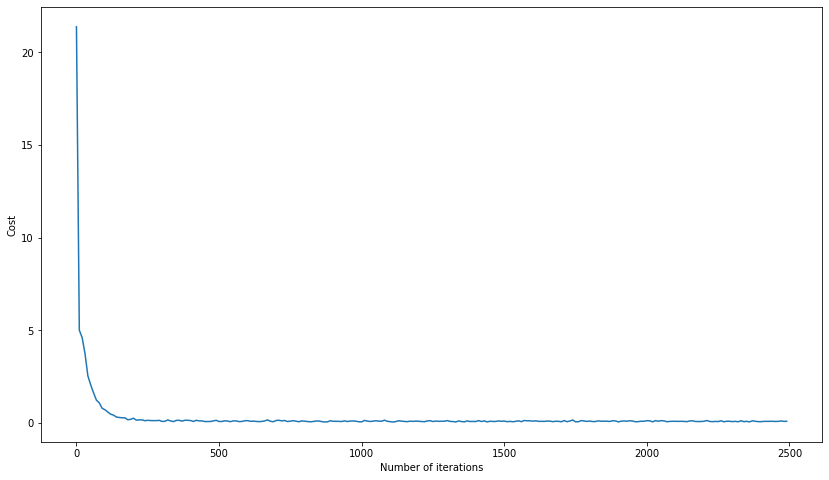

In [20]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.plot(list(range(0,len(cost) * 10,10)),cost)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')

In [21]:
test_X_mini_batches = mini_batches(X = test_X,Y = 0)
predictions = np.array([])
for mini_batch in test_X_mini_batches:
    pred = np.argmax(forward_propagation(mini_batch,parameters)['A2'], axis=0)
    predictions = np.append(predictions,pred)
predictions

array([2., 0., 9., ..., 7., 8., 9.])

In [22]:
submission = pd.DataFrame([np.arange(1,28001),predictions]).T
submission.columns = ['ImageId','Label']
submission = submission.astype('int')
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [23]:
submission.to_csv('submission.csv', index=False)